In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from pyreadr import read_r
import seaborn as sns
import matplotlib.pyplot as plt

if '__file__' in globals():
    PROJECT_PATH = Path(__file__).parent.resolve()
else:
    PROJECT_PATH = Path(globals()['_dh'][0])

Načtěte datový soubor a rozdělte sledovanou proměnnou na příslušné dvě pozorované skupiny.

In [2]:
data: pd.DataFrame = read_r(PROJECT_PATH / 'case0301.rda')['case0301']  # type: ignore
seeded: pd.DataFrame = data.loc[data['Treatment'] == 'Seeded', ['Rainfall']]
unseeded: pd.DataFrame = data.loc[data['Treatment'] == 'Unseeded', ['Rainfall']]
cd = {
    'seeded': seeded['Rainfall'],
    'unseeded': unseeded['Rainfall'],
}

x_all = sorted(data['Rainfall'])

Stručně popište data a zkoumaný problém.

In [3]:
data.__doc__ = """Data popisujú množstvo zrážok(Objem/ft²),
ktoré spadne pri zhadzovaní a bez zhadzovania Iodidu strieborného na mračná.
Úlohou je zistiť či tento proces zvyšuje množstvo zrážok. """

Pro každou skupinu zvlášť odhadněte střední hodnotu, rozptyl a medián příslušného rozdělení.

In [4]:
mean = {k: v.mean() for k, v in cd.items()}
std = {k: v.std() for k, v in cd.items()}
median = {k: v.median() for k, v in cd.items()}

print(f'{mean=}')
print(f'{std=}')
print(f'{median=}')

mean={'seeded': np.float64(441.9846234871791), 'unseeded': np.float64(164.58845985852756)}
std={'seeded': np.float64(650.787188702316), 'unseeded': np.float64(278.4263986434599)}
median={'seeded': np.float64(221.5999984741211), 'unseeded': np.float64(44.19999885559082)}


Pro každou skupinu zvlášť odhadněte hustotu a distribuční funkci pomocí histogramu a empirické distribuční funkce.

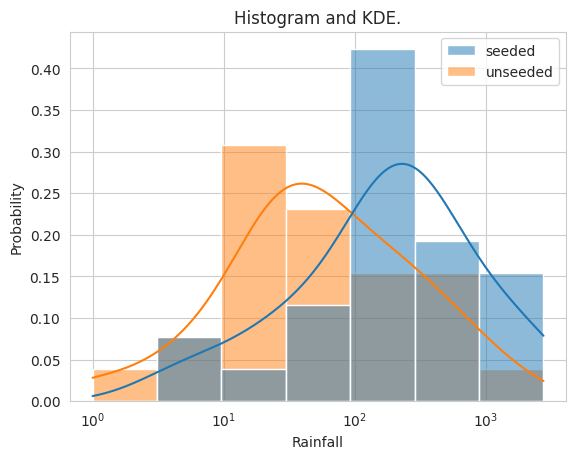

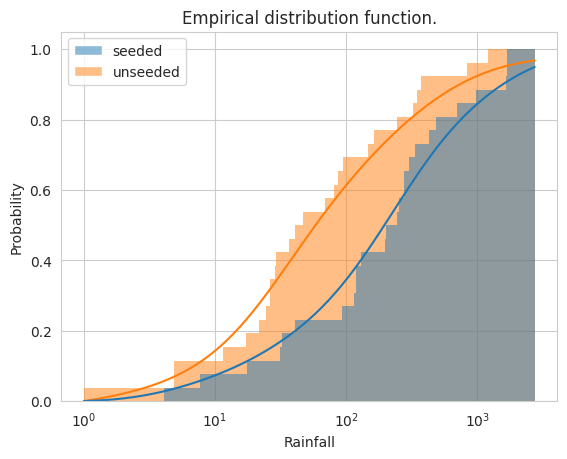

In [5]:
ax = sns.histplot(
    cd,
    stat='probability',
    bins='fd',
    common_norm=False,
    log_scale=10,
    kde=True,
    multiple='layer',
)
ax.set(
    title='Histogram and KDE.',
    xlabel='Rainfall',
)
plt.show()

ax = sns.histplot(
    cd,
    stat='probability',
    bins=np.log10(x_all),
    common_norm=False,
    log_scale=10,
    kde=True,
    multiple='layer',
    cumulative=True,
)
ax.set(
    title='Empirical distribution function.',
    xlabel='Rainfall',
)
plt.show()

Pro každou skupinu zvlášť najděte nejbližší rozdělení:
1) Odhadněte parametry normálního, exponenciálního a rovnoměrného rozdělení. (+ LogNormal)
2) Zaneste příslušné hustoty s odhadnutými parametry do grafů histogramu.
3) Diskutujte, které z rozdělení odpovídá pozorovaným datům nejlépe.


In [6]:
from scipy.stats import norm, expon, uniform, lognorm

distributions = {
    'normal': norm,
    'exponential': expon,
    'uniform': uniform,
    'log normal': lognorm,
}

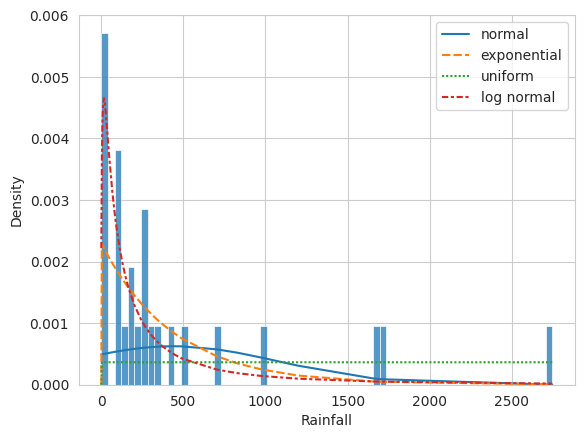

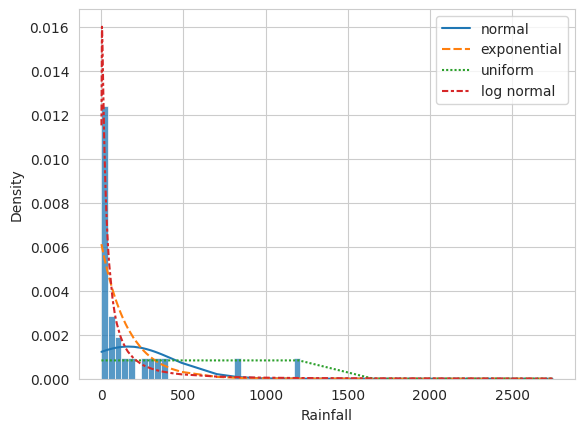

In [7]:
bins = np.histogram_bin_edges(x_all, bins='stone')  # bins computed from all samples
for category, cat_data in cd.items():
    # bins = np.histogram_bin_edges(cat_data, bins='stone')    
    fitted = pd.DataFrame(index=x_all)
    for name, dist in distributions.items():
        param = dist.fit(cat_data)
        fitted[name] = dist.pdf(x_all, *param)
        
    sns.histplot(cat_data, stat='density', bins=bins)
    sns.lineplot(fitted)
    plt.show()

Z vynesených grafou vyzerá log-normál ako napresnejšie rozdelenie. Druhé najlepšie vyzerá byť exponenciálne rozdelenie.

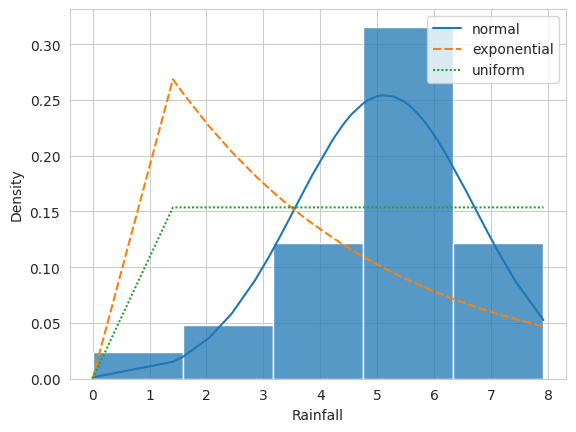

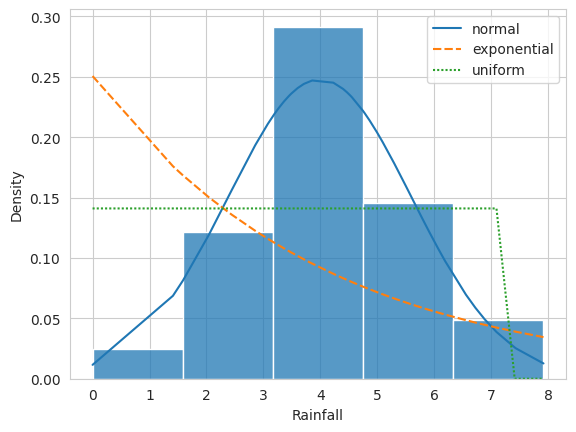

In [8]:
# To isté ale zrážky sú zlogaritmované.
x_all_log = np.log(x_all)
cd_log = {cat: np.log(d) for cat, d in cd.items()}

bins = np.histogram_bin_edges(x_all_log, bins='stone')
for category, cat_data in cd_log.items():
    # bins = np.histogram_bin_edges(cat_data, bins='stone')    
    fitted = pd.DataFrame(index=x_all_log)
    for name, dist in distributions.items():
        if name == 'log normal':  # nepotrebujeme loglog normal
            continue
        param = dist.fit(cat_data)
        fitted[name] = dist.pdf(x_all_log, *param)
        
    sns.histplot(cat_data, stat='density', bins=bins)
    sns.lineplot(fitted)
    plt.show()

In [9]:
def nllf(distribution, sample, parameters=None):
    """Negative log likelihood function."""
    if parameters is None:
        parameters = distribution.fit(sample)
    return -np.sum(np.log(distribution.pdf(sample, *parameters)))

sample_nllf = {dist_name: 0 for dist_name in distributions}
for cat_name, cat_data in cd.items():
    print(f'{cat_name}:')
    for d_name, dist in distributions.items():
        c_nllf = nllf(dist, cat_data)
        print(f'\t{d_name}: nllf={c_nllf}')
        sample_nllf[d_name] += c_nllf

best_distribution_name = min(sample_nllf, key=sample_nllf.get)
best_distribution = distributions[best_distribution_name]
print('best_distribution:', best_distribution.__class__.__name__)

seeded:
	normal: nllf=204.81528252428538
	exponential: nllf=184.1308419391487
	uniform: nllf=205.82277379300922
	log normal: nllf=182.05274561968068
unseeded:
	normal: nllf=182.7405300059686
	exponential: nllf=158.53120095588397
	uniform: nllf=184.37664077798962
	log normal: nllf=153.01164800751042
best_distribution: lognorm_gen


Pro každou skupinu zvlášť vygenerujte náhodný výběr o 100 hodnotách z rozdělení, které jste zvolili jako nejbližší, s parametry odhadnutými v předchozím bodě. Porovnejte histogram simulovaných hodnot s pozorovanými daty.

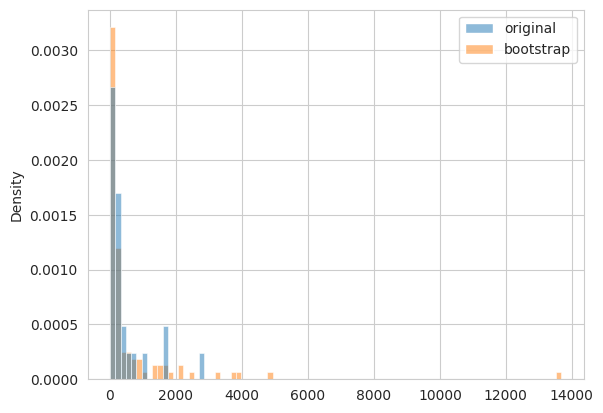

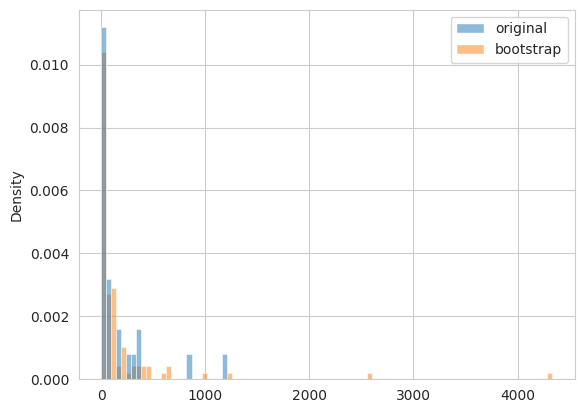

In [10]:
dist_parameters = {
    cat: best_distribution.fit(d) for cat, d in cd.items()
}

N = 100
bootstrap = {
    cat: best_distribution.rvs(*param, size=N)
            for cat, param in dist_parameters.items()
}

bins = np.histogram_bin_edges(x_all, bins='stone')
for cat, original in cd.items():
    sampled = bootstrap[cat]
    
    sns.histplot(
        {
            'original': original,
            'bootstrap': sampled,
        },
        stat='density',
        common_norm=False
    )
    plt.show()

Pro každou skupinu zvlášť spočítejte oboustranný 95% konfidenční interval pro střední hodnotu.

In [11]:
# for exponential distribution we can calculate
# 95% CI from mean and std

from scipy.stats import t  # use t-distribution for small samples size

identity = lambda x: x
sample_transform = (np.log, np.exp) if best_distribution is lognorm else (identity,) * 2

confidence = 0.95
CI = {}
for cat, samples in cd.items():
    _f, _if =  sample_transform
    samples = _f(samples)
    t_score = t.ppf(0.5 + confidence / 2, df=len(samples)-1)
    sample_mean = samples.mean()
    sample_std = samples.std()
    st_error = sample_std / np.sqrt(len(samples))  # todo: for log-norm  https://jse.amstat.org/v13n1/olsson.html

    ci_low = sample_mean - st_error * t_score
    ci_high = sample_mean + st_error * t_score
    CI[cat] = (ci_low, ci_high)
    print(f'{cat} 95% CI: [{_if(ci_low)}, {_if(ci_high)}]')

seeded 95% CI: [88.9548786666789, 323.8383028295356]
unseeded 95% CI: [27.861591267858078, 104.95820010557532]


Pro každou skupinu zvlášť otestujte na hladině významnosti 5 % hypotézu, zda je střední hodnota rovná hodnotě K (parametr úlohy), proti oboustranné alternativě. Můžete použít buď výsledek z předešlého bodu, nebo výstup z příslušné vestavěné funkce vašeho softwaru.

In [12]:
# test hypothesis H₀: μ = K
K = 6
significance = 1 - confidence
for cat, cat_ci in CI.items():
    print(f'Hypothesis H₀: μ({cat}) = {K} ', end='')
    if cat_ci[0] <= K <= cat_ci[1]:
        print(f'is plausible at {significance=:.2f}')
    else:
        print(f'rejected with {confidence=:.2f}')

Hypothesis H₀: μ(seeded) = 6 rejected with confidence=0.95
Hypothesis H₀: μ(unseeded) = 6 rejected with confidence=0.95


Na hladině významnosti 5 % otestujte, jestli mají pozorované skupiny stejnou střední hodnotu. Typ testu a alternativy stanovte tak, aby vaše volba nejlépe korespondovala s povahou zkoumaného problému.

In [13]:
# Likelihood ratio test (LRT)  https://en.wikipedia.org/wiki/Likelihood-ratio_test
# null_hypothesis: both samples(seeded and unseeded) are from same distribution
# alternate_hypothesis: samples are from different distributions
from scipy.stats import chi2

significance = 0.05

null_parameters = best_distribution.fit(data['Rainfall'], floc=0)
alt_parameters = {
    cat_name: best_distribution.fit(cat_data, floc=0)
    for cat_name, cat_data in cd.items()
}

LR = 2 * (nllf(best_distribution, data['Rainfall'], null_parameters)
          - nllf(best_distribution, cd['seeded'], alt_parameters['seeded'])
          - nllf(best_distribution, cd['unseeded'], alt_parameters['unseeded']))

null_param_cnt = len(null_parameters) - 1  # loc is fixed
alt_param_cnt = 2 * (len(alt_parameters['seeded']) - 1)
df = abs(null_param_cnt - alt_param_cnt)
p_value = 1 - chi2.cdf(LR, df=df)

print(f'Testing at significance level p={significance}:')
print(f'    H₀: seeded and unseeded samples follow same {best_distribution_name} distribution')
print(f'    H₁: seeded and unseeded are from different {best_distribution_name} distributions')

print(f'Measured {p_value=:.2f}')
if p_value < significance:
    print('Null hypothesis rejected, distributions are significantly different.')
else:
    print('Null hypothesis is plausible.')

Testing at significance level p=0.05:
    H₀: seeded and unseeded samples follow same log normal distribution
    H₁: seeded and unseeded are from different log normal distributions
Measured p_value=0.04
Null hypothesis rejected, distributions are significantly different.
